In [ ]:
pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
import optuna
from optuna.integration import XGBoostPruningCallback
sns.set_theme(style="darkgrid")

In [3]:
# Load Datasets in pandas dataframe
train_df = pd.read_csv("/content/drive/MyDrive/Dacon_APT/train.csv") #경로 확인
test_df = pd.read_csv("/content/drive/MyDrive/Dacon_APT/test.csv")

In [4]:
#괄호와 괄호안내용 제거
regex = "\(.*\)|\s-\s.*"
for i in tqdm(range(len(train_df))):
   train_df.at[i, 'apt'] = re.sub(regex, '', train_df.at[i, 'apt'])
for i in tqdm(range(len(test_df))):
   test_df.at[i, 'apt'] = re.sub(regex, '', test_df.at[i, 'apt'])   

100%|██████████| 5463/5463 [00:00<00:00, 64610.54it/s]


In [5]:
# 같은 아파트 이름을 갖는 수를 저장하는 apt_counts 열 생성
train_df['apt_counts'] = 0
train_df.groupby('apt')['apt_counts'].count()
train_df = pd.merge(train_df, train_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

test_df['apt_counts'] = 0
test_df.groupby('apt')['apt_counts'].count()
test_df = pd.merge(test_df, test_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

train_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000,1
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500,13


In [6]:
# top 10 시공사 아파트 여부를 나타내는 컬럼 생성
train_df['top10'] = 0
test_df['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

train_df['apt'] = train_df['apt'].fillna('others')
# top 10 시공사면 1, 아니면 0
for i, brand in enumerate(top10):
    train_df.loc[train_df['apt'].str.contains(brand), 'top10'] = 1 
    test_df.loc[test_df['apt'].str.contains(brand), 'top10'] = 1

In [7]:
# 데이터에 많이 있는 아파트 대표 25개 리스트
apt_names = ['그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']
# top 10 시공사 키워드와 25개 리스트를 통합
apt_names_list = top10 + apt_names

# `apt_names_list`의 키워드에 해당하는 아파트명이 있는지 여부를 나타내는 새로운 컬럼 생성
train_df['transformed'] = False
test_df['transformed'] = False

# `apt_names_list`의 키워드에 아파트명이 포함되면 해당 키워드로 아파트명을 통일함
# 그리고 `transformed` 컬럼값을 True로 변경
for a in tqdm(apt_names_list):
    train_df.loc[train_df['apt'].str.contains(a), 'apt'] = a
    test_df.loc[test_df['apt'].str.contains(a), 'apt'] = a
    train_df.loc[train_df['apt'].str.contains(a), 'transformed'] = True
    test_df.loc[test_df['apt'].str.contains(a), 'transformed'] = True

# 아파트 이름이 변경되지 않았을 경우(`transformed=False` 일 경우) 아파트명을 'others'로 변경
for a in tqdm(apt_names):
    train_df.loc[~train_df['transformed'], 'apt'] = 'others'
    test_df.loc[~test_df['transformed'] , 'apt'] = 'others'

100%|██████████| 25/25 [00:00<00:00, 41.42it/s]


In [8]:
print(train_df['apt'].nunique(), test_df['apt'].nunique())

35 35


In [9]:
# 아파트별 가격의 평균 내림차순 정렬
apt_price = train_df.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환전\n', apt_price[:5])

for i, a in enumerate(list(apt_price.index)):
    train_df.loc[train_df['apt'] == a, 'apt'] = i # 라벨 인코딩
    test_df.loc[test_df['apt'] == a, 'apt'] = i
apt_price = train_df.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환후\n', apt_price[:5])

변환전
 apt
잠실      91273.525326
파크리오    88739.646736
자이      79838.112467
래미안     64184.531289
아이파크    63115.982726
Name: transaction_real_price, dtype: float64
변환후
 apt
0    91273.525326
1    88739.646736
2    79838.112467
3    64184.531289
4    63115.982726
Name: transaction_real_price, dtype: float64


In [10]:
# test 시작 거래연월인 인덱스 저장
test_start = train_df.loc[train_df['transaction_year_month'] == 201701, 'transaction_year_month'].index[0]

In [11]:
# 완공연도에서 최소연도를 뺌으로써 완공연도 라벨인코딩
print('변환전\n', train_df['year_of_completion'].unique()[:5])
train_df['year_of_completion'] = train_df['year_of_completion'] - train_df['year_of_completion'].min()
test_df['year_of_completion'] = test_df['year_of_completion'] - test_df['year_of_completion'].min()
print('변환후\n', train_df['year_of_completion'].unique()[:5])

# 연월 증가하는 순으로 라벨 인코딩
print('train 변환전\n', train_df['transaction_year_month'].unique()[:5])
print('test 변환전\n', test_df['transaction_year_month'].unique()[:5])
le = LabelEncoder()
train_df['transaction_year_month'] = le.fit_transform(train_df['transaction_year_month'])
# test는 다음과 같이 처리
test_df['transaction_year_month'] = test_df['transaction_year_month'] - test_df['transaction_year_month'].min() + train_df.at[test_start, 'transaction_year_month']
print('train 변환후\n', train_df['transaction_year_month'].unique()[:5])
print('test 변환후\n', test_df['transaction_year_month'].unique()[:5])

# 필요없는 열 제거
train_df = train_df.drop(['jibun', 'transaction_date', 'addr_kr'], axis=1)
test_df = test_df.drop(['jibun', 'transaction_date', 'addr_kr'], axis=1)

변환전
 [2002 1973 2007 2003 2004]
변환후
 [41 12 46 42 43]
train 변환전
 [200801 200802 200803 200804 200805]
test 변환전
 [201711 201708 201710 201707 201712]
train 변환후
 [0 1 2 3 4]
test 변환후
 [118 115 117 114 119]


In [12]:
seoul_set = set(train_df.loc[train_df['city']=='서울특별시', 'dong'])
busan_set = set(train_df.loc[train_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set 
print(same_dong)

seoul_set = set(test_df.loc[test_df['city']=='서울특별시', 'dong'])
busan_set = set(test_df.loc[test_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set 
print(same_dong)

{'부암동', '사직동', '중동', '송정동'}
{'부암동', '사직동', '중동', '송정동'}


In [13]:
for d in same_dong:
    train_df.loc[(train_df['city']=='서울특별시') & (train_df['dong']==d), 'dong'] = '서울' + d
    train_df.loc[(train_df['city']=='부산광역시') & (train_df['dong']==d), 'dong'] = '부산' + d
    test_df.loc[(test_df['city']=='서울특별시') & (test_df['dong']==d), 'dong'] = '서울' + d
    test_df.loc[(test_df['city']=='부산광역시') & (test_df['dong']==d), 'dong'] = '부산' + d
    

seoul_set = set(train_df.loc[train_df['city']=='서울특별시', 'dong'])
busan_set = set(train_df.loc[train_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set
print(same_dong)  

set()


In [14]:
train_df.loc[train_df['dong'].str.contains('장충동')].groupby('dong')['transaction_real_price'].\
agg('mean')

dong
장충동1가    269888.888889
장충동2가      6628.421053
Name: transaction_real_price, dtype: float64

In [15]:
dong_price = train_df.groupby('dong')['transaction_real_price'].agg('mean').sort_values(ascending=False)
dong_price[:20]

dong
장충동1가     269888.888889
압구정동      164534.722914
청암동       161403.700000
용산동5가     153497.331633
회현동2가     139906.140351
반포동       132489.395651
한남동       122593.293264
서빙고동      116547.239777
대치동       116320.538909
남대문로5가    113153.604651
도곡동       110655.655354
청담동       110289.411168
교남동       108600.000000
내수동       107899.014778
주성동       106000.000000
하중동       105900.477833
삼성동       101379.971621
잠실동       101166.337275
동자동        99472.876033
동빙고동       99057.552239
Name: transaction_real_price, dtype: float64

In [16]:
# 가격기준으로 동을 정렬한 리스트를 바탕으로 dong에 대해 라벨 인코딩 진행 - 477 it.
for i, d in tqdm(enumerate(list(dong_price.index)), total=len(dong_price)):
    train_df.loc[train_df['dong'] == d, 'dong'] = i
    test_df.loc[test_df['dong'] == d, 'dong'] = i
train_df.head()

100%|██████████| 477/477 [00:35<00:00, 13.57it/s]


,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,top10,transformed
0,0,7622,서울특별시,138,23,84.82,41,0,2,37500,13,0,False
1,1,5399,서울특별시,65,23,99.17,12,0,6,20000,1,0,False
2,2,3578,서울특별시,65,23,84.74,46,0,6,38500,13,0,False
3,3,10957,서울특별시,13,23,146.39,42,0,15,118000,55,0,False
4,4,10639,서울특별시,13,23,194.43,43,0,3,120000,15,0,False


In [17]:
# 최소값이 -4이므로 4를 더해서 음수를 없애고 순서형범주처리
print('변환전\n', train_df['floor'].values[:5])
train_df['floor'] = train_df['floor'].map(lambda x: x+4)
test_df['floor'] = test_df['floor'].map(lambda x: x+1)
print('변환후\n', train_df['floor'].values[:5])

변환전
 [ 2  6  6 15  3]
변환후
 [ 6 10 10 19  7]


<Figure size 432x288 with 0 Axes>

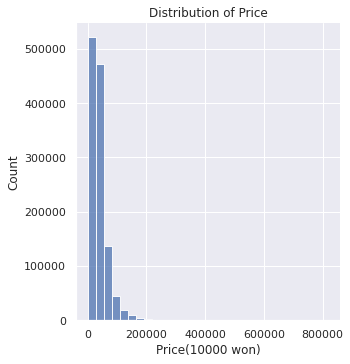

In [18]:
# train price
plt.figure()
sns.displot(train_df['transaction_real_price'], bins=30)
plt.xlabel('Price(10000 won)')
plt.title('Distribution of Price')
plt.show()

In [19]:
# 가격 로그 변환 후 원래 가격 따로 저장
train_df['log_price'] = np.log1p(train_df['transaction_real_price'])
real_price = train_df['transaction_real_price'] # 원래 가격
train_df.drop('transaction_real_price', axis=1, inplace=True)
train_df.head(1)

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,apt_counts,top10,transformed,log_price
0,0,7622,서울특별시,138,23,84.82,41,0,6,13,0,False,10.532123


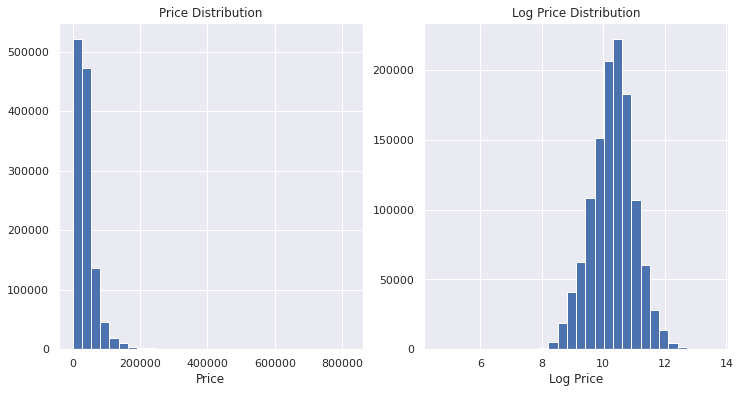

In [20]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(real_price, bins=30)
ax1.set_title('Price Distribution')
ax1.set_xlabel('Price')

ax2.hist(train_df['log_price'], bins=30)
ax2.set_title('Log Price Distribution')
ax2.set_xlabel('Log Price')

plt.show()

<Figure size 432x288 with 0 Axes>

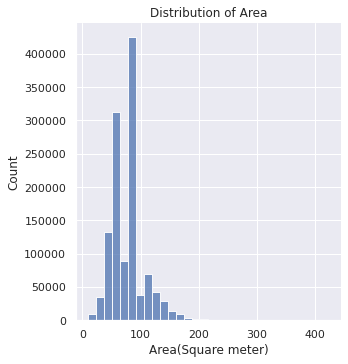

In [21]:
# train area
plt.figure()
sns.displot(train_df['exclusive_use_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.title('Distribution of Area')
plt.show()

In [22]:
# 면적 로그 변환 후 원래 면적 따로 저장
train_df['log_area'] = np.log1p(train_df['exclusive_use_area'])
test_df['log_area'] = np.log1p(test_df['exclusive_use_area'])
area = train_df['exclusive_use_area'] # 원래 가격
train_df.drop('exclusive_use_area', axis=1, inplace=True)
test_df.drop('exclusive_use_area', axis=1, inplace=True)
train_df.head(1)

,transaction_id,apartment_id,city,dong,apt,year_of_completion,transaction_year_month,floor,apt_counts,top10,transformed,log_price,log_area
0,0,7622,서울특별시,138,23,41,0,6,13,0,False,10.532123,4.452252


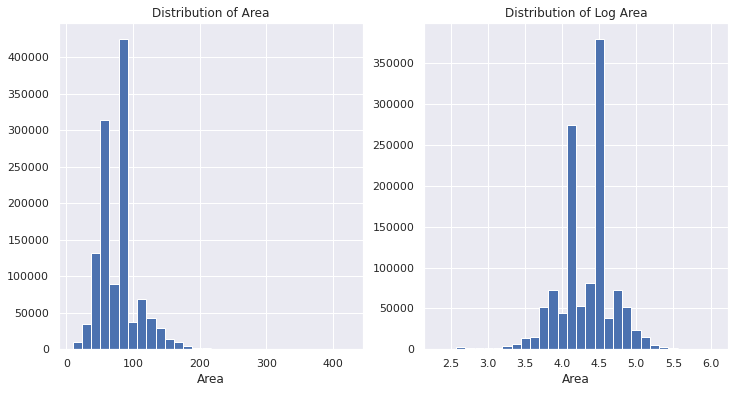

In [23]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(area, bins=30)
ax1.set_title('Distribution of Area')
ax1.set_xlabel('Area')

ax2.hist(train_df['log_area'], bins=30)
ax2.set_title('Distribution of Log Area')
ax2.set_xlabel('Area')

plt.show()

In [24]:
drop_col = ['transaction_id', 'apartment_id', 'apt_counts', 'transformed']

train_df['city'] = train_df['city'].map(lambda x: 1 if x == '서울특별시' else 0)
test_df['city'] = test_df['city'].map(lambda x: 1 if x == '서울특별시' else 0)

In [25]:
train_df.drop(drop_col, axis=1, inplace=True)
test_df.drop(drop_col, axis=1, inplace=True)
train_df.head(1)

,city,dong,apt,year_of_completion,transaction_year_month,floor,top10,log_price,log_area
0,1,138,23,41,0,6,0,10.532123,4.452252


In [26]:
train_df['dong'] = train_df['dong'].astype('int64')
train_df['apt'] = train_df['apt'].astype('int64')
test_df['dong'] = test_df['dong'].astype('int64')
test_df['apt'] = test_df['apt'].astype('int64')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216553 entries, 0 to 1216552
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   city                    1216553 non-null  int64  
 1   dong                    1216553 non-null  int64  
 2   apt                     1216553 non-null  int64  
 3   year_of_completion      1216553 non-null  int64  
 4   transaction_year_month  1216553 non-null  int64  
 5   floor                   1216553 non-null  int64  
 6   top10                   1216553 non-null  int64  
 7   log_price               1216553 non-null  float64
 8   log_area                1216553 non-null  float64
dtypes: float64(2), int64(7)
memory usage: 132.8 MB


In [27]:
train_X, train_y = train_df.drop('log_price', axis=1), train_df['log_price']
print(train_X.shape, train_y.shape)

(1216553, 8) (1216553,)


In [28]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [29]:
reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

In [30]:
models = []
scores = []
for model in [reg, ridge, lasso, Enet, DTree, rf, model_xgb, model_lgb]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


1 FOLDS: LinearRegression RMSLE: 0.1970
2 FOLDS: LinearRegression RMSLE: 0.2509
3 FOLDS: LinearRegression RMSLE: 0.2142
4 FOLDS: LinearRegression RMSLE: 0.3582
5 FOLDS: LinearRegression RMSLE: 0.3423
6 FOLDS: LinearRegression RMSLE: 0.3490
7 FOLDS: LinearRegression RMSLE: 0.3382
8 FOLDS: LinearRegression RMSLE: 0.2909
9 FOLDS: LinearRegression RMSLE: 0.2620
10 FOLDS: LinearRegression RMSLE: 0.2850

LinearRegression mean RMSLE: 0.2888


Ridge Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 10.30it/s]


1 FOLDS: Ridge RMSLE: 0.1970
2 FOLDS: Ridge RMSLE: 0.2509
3 FOLDS: Ridge RMSLE: 0.2142
4 FOLDS: Ridge RMSLE: 0.3582
5 FOLDS: Ridge RMSLE: 0.3423
6 FOLDS: Ridge RMSLE: 0.3490
7 FOLDS: Ridge RMSLE: 0.3382
8 FOLDS: Ridge RMSLE: 0.2909
9 FOLDS: Ridge RMSLE: 0.2620
10 FOLDS: Ridge RMSLE: 0.2850

Ridge mean RMSLE: 0.2888


Lasso Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


1 FOLDS: Lasso RMSLE: 0.1993
2 FOLDS: Lasso RMSLE: 0.2505
3 FOLDS: Lasso RMSLE: 0.2148
4 FOLDS: Lasso RMSLE: 0.3627
5 FOLDS: Lasso RMSLE: 0.3373
6 FOLDS: Lasso RMSLE: 0.4183
7 FOLDS: Lasso RMSLE: 0.3587
8 FOLDS: Lasso RMSLE: 0.3056
9 FOLDS: Lasso RMSLE: 0.2639
10 FOLDS: Lasso RMSLE: 0.2792

Lasso mean RMSLE: 0.2990


ElasticNet Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  5.24it/s]


1 FOLDS: ElasticNet RMSLE: 0.2063
2 FOLDS: ElasticNet RMSLE: 0.2532
3 FOLDS: ElasticNet RMSLE: 0.2177
4 FOLDS: ElasticNet RMSLE: 0.3678
5 FOLDS: ElasticNet RMSLE: 0.3343
6 FOLDS: ElasticNet RMSLE: 0.3820
7 FOLDS: ElasticNet RMSLE: 0.3596
8 FOLDS: ElasticNet RMSLE: 0.3061
9 FOLDS: ElasticNet RMSLE: 0.2676
10 FOLDS: ElasticNet RMSLE: 0.2798

ElasticNet mean RMSLE: 0.2974


DecisionTreeRegressor Cross Validations...: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


1 FOLDS: DecisionTreeRegressor RMSLE: 0.1892
2 FOLDS: DecisionTreeRegressor RMSLE: 0.2700
3 FOLDS: DecisionTreeRegressor RMSLE: 0.2172
4 FOLDS: DecisionTreeRegressor RMSLE: 0.3591
5 FOLDS: DecisionTreeRegressor RMSLE: 0.3873
6 FOLDS: DecisionTreeRegressor RMSLE: 0.3512
7 FOLDS: DecisionTreeRegressor RMSLE: 0.3719
8 FOLDS: DecisionTreeRegressor RMSLE: 0.3128
9 FOLDS: DecisionTreeRegressor RMSLE: 0.2985
10 FOLDS: DecisionTreeRegressor RMSLE: 0.3348

DecisionTreeRegressor mean RMSLE: 0.3092


RandomForestRegressor Cross Validations...: 100%|██████████| 10/10 [27:02<00:00, 162.23s/it]


1 FOLDS: RandomForestRegressor RMSLE: 0.1730
2 FOLDS: RandomForestRegressor RMSLE: 0.2497
3 FOLDS: RandomForestRegressor RMSLE: 0.2106
4 FOLDS: RandomForestRegressor RMSLE: 0.3586
5 FOLDS: RandomForestRegressor RMSLE: 0.3609
6 FOLDS: RandomForestRegressor RMSLE: 0.2969
7 FOLDS: RandomForestRegressor RMSLE: 0.3207
8 FOLDS: RandomForestRegressor RMSLE: 0.2675
9 FOLDS: RandomForestRegressor RMSLE: 0.2708
10 FOLDS: RandomForestRegressor RMSLE: 0.2516

RandomForestRegressor mean RMSLE: 0.2760


XGBRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

[05:21:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  10%|█         | 1/10 [00:24<03:42, 24.68s/it]

[05:22:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  20%|██        | 2/10 [01:07<04:41, 35.24s/it]

[05:23:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  30%|███       | 3/10 [02:22<06:15, 53.68s/it]

[05:24:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [04:06<07:20, 73.39s/it]

[05:25:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [06:18<07:51, 94.40s/it]

[05:28:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  60%|██████    | 6/10 [09:03<07:53, 118.42s/it]

[05:30:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  70%|███████   | 7/10 [12:16<07:08, 142.97s/it]

[05:34:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  80%|████████  | 8/10 [16:03<05:39, 169.56s/it]

[05:37:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  90%|█████████ | 9/10 [20:15<03:15, 195.51s/it]

[05:42:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...: 100%|██████████| 10/10 [24:58<00:00, 149.89s/it]


1 FOLDS: XGBRegressor RMSLE: 0.1907
2 FOLDS: XGBRegressor RMSLE: 0.2292
3 FOLDS: XGBRegressor RMSLE: 0.1882
4 FOLDS: XGBRegressor RMSLE: 0.3722
5 FOLDS: XGBRegressor RMSLE: 0.3474
6 FOLDS: XGBRegressor RMSLE: 0.2681
7 FOLDS: XGBRegressor RMSLE: 0.2722
8 FOLDS: XGBRegressor RMSLE: 0.2017
9 FOLDS: XGBRegressor RMSLE: 0.2318
10 FOLDS: XGBRegressor RMSLE: 0.1174

XGBRegressor mean RMSLE: 0.2419


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [01:06<00:00,  6.68s/it]

1 FOLDS: LGBMRegressor RMSLE: 0.1853
2 FOLDS: LGBMRegressor RMSLE: 0.2256
3 FOLDS: LGBMRegressor RMSLE: 0.1887
4 FOLDS: LGBMRegressor RMSLE: 0.3412
5 FOLDS: LGBMRegressor RMSLE: 0.3229
6 FOLDS: LGBMRegressor RMSLE: 0.2633
7 FOLDS: LGBMRegressor RMSLE: 0.2634
8 FOLDS: LGBMRegressor RMSLE: 0.2120
9 FOLDS: LGBMRegressor RMSLE: 0.2416
10 FOLDS: LGBMRegressor RMSLE: 0.1506

LGBMRegressor mean RMSLE: 0.2395


In [31]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,LinearRegression,0.288778
1,Ridge,0.288777
2,Lasso,0.299014
3,ElasticNet,0.297440
4,DecisionTreeRegressor,0.309207
5,RandomForestRegressor,0.276021
6,XGBRegressor,0.241884
7,LGBMRegressor,0.239456


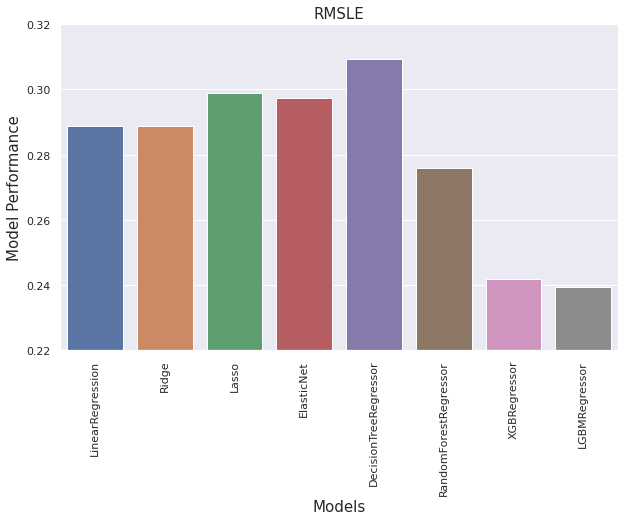

In [32]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.22, 0.32)
plt.title('RMSLE', fontsize=15)
plt.show()

In [33]:
cut = int(len(train_df)*0.8)
h_train = train_df[:cut]
h_valid = train_df[cut:]

h_train_X = h_train.drop('log_price', axis=1)
h_train_y = h_train['log_price']
h_valid_X = h_valid.drop('log_price', axis=1)
h_valid_y = h_valid['log_price']
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(973242, 8) (973242,) (243311, 8) (243311,)


In [34]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(h_train_X, label=h_train_y)
    dtest = lgb.Dataset(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
    rmse = RMSE(h_valid_y, lgb_model.predict(h_valid_X))
    return rmse
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2021-10-27 05:47:59,204] A new study created in memory with name: no-name-066ed836-d632-44f5-a467-c33fa32ce85b
[I 2021-10-27 05:49:19,717] Trial 0 finished with value: 0.7371358593423419 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'subsample': 0.6315909175774905}. Best is trial 0 with value: 0.7371358593423419.
[I 2021-10-27 05:50:48,653] Trial 1 finished with value: 0.7369466723386557 and parameters: {'max_depth': 5, 'learning_rate': 1.5430400149097381e-07, 'n_estimators': 2306, 'min_child_samples': 21, 'subsample': 0.4337244827306443}. Best is trial 1 with value: 0.7369466723386557.
[I 2021-10-27 05:50:53,353] Trial 2 finished with value: 0.4897832583187339 and parameters: {'max_depth': 11, 'learning_rate': 0.005252427629146827, 'n_estimators': 111, 'min_child_samples': 54, 'subsample': 0.8422371309477078}. Best is trial 2 with value: 0.4897832583187339.
[I 2021-10-27 05:51:32,686] Trial 3 finished with 

In [35]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.20736492479638002,
params {'max_depth': 13, 'learning_rate': 0.009480267802321527, 'n_estimators': 2566, 'min_child_samples': 84, 'subsample': 0.5742064444292969}


In [36]:
final_lgb_model = lgb.LGBMRegressor(**trial_params)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(test_df)

final_lgb_pred

array([10.12622556,  9.21646546,  9.3808709 , ..., 11.01138465,
       10.4479061 , 10.04612572])

<BarContainer object of 8 artists>

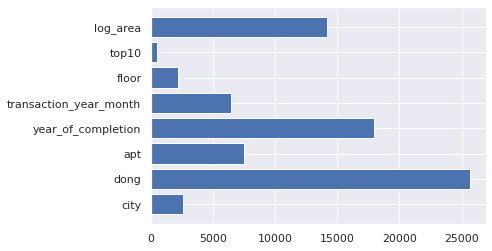

In [37]:
plt.barh(train_X.columns, final_lgb_model.feature_importances_)


In [38]:
final_pred_sub = np.expm1(final_lgb_pred)
final_pred_sub

array([24988.86340105, 10060.43883539, 11858.33850216, ...,
       60558.68281285, 34471.11793207, 23065.24847308])

In [39]:
sub = pd.read_csv('/content/drive/MyDrive/Dacon_APT/test.csv')
sub_df = pd.DataFrame({'transaction_id': sub['transaction_id'], 'transaction_real_price': final_pred_sub})
sub_df

,transaction_id,transaction_real_price
0,1145756,24988.863401
1,1198704,10060.438835
2,1222384,11858.338502
3,1179897,114023.908643
4,1223091,44351.189137
...,...,...
5458,1174640,57425.614092
5459,1175575,156253.234490
5460,1157024,60558.682813
5461,1136863,34471.117932


In [40]:
sub_df.to_csv('/content/drive/MyDrive/Dacon_APT/submission_lgb.csv', index=False)